# Project 3


# Movie Genre Classification

## Integrantes

Laura Gutierrez Código 201015209

Fernando Bautista Código 202027865

Fredi Baron Código 202027522

Ingrid Hernández Código 202028041

## Sample Submission

In [2]:
import pandas as pd
import os
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
#from skmultilearn.problem_transform import ClassifierChain
#from skmultilearn.problem_transform import LabelPowerset


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataTraining = pd.read_csv('C:/Users/ihernandez/Desktop/Guardar en Disco Duro/Modelos Avanzados 1/Proyecto 3/dataTraining.csv', parse_dates=True)
dataTesting = pd.read_csv('C:/Users/ihernandez/Desktop/Guardar en Disco Duro/Modelos Avanzados 1/Proyecto 3/dataTesting.csv', parse_dates=True)

In [4]:
dataTraining.head()

,Unnamed: 0,year,title,plot,genres,rating
0,3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
1,900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
2,6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
3,4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
4,2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
dataTesting.head()

,Unnamed: 0,year,title,plot
0,1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
1,4,1978,Midnight Express,"the true story of billy hayes , an american c..."
2,5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
3,6,1950,Crisis,husband and wife americans dr . eugene and mr...
4,7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


## Exploración de los datos

In [6]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

In [7]:
# Total de generos en el data set
all_genres = sum(dataTraining['genres'],[])
len(set(all_genres))

24

In [8]:
all_genres = nltk.FreqDist(all_genres) 
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [9]:
g = all_genres_df.nlargest(columns="Count", n = 50) 

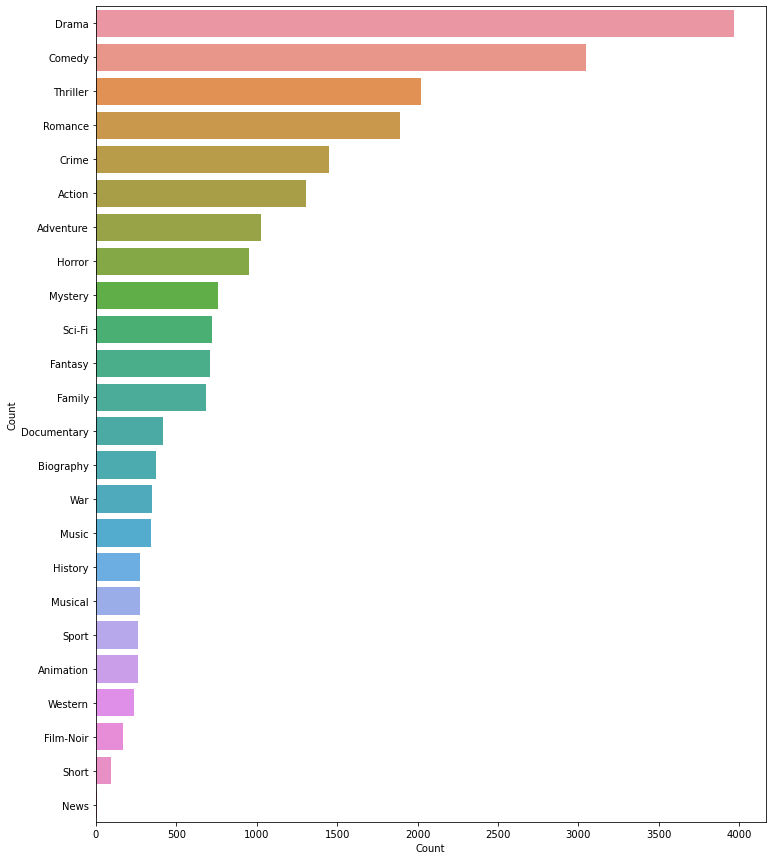

In [10]:
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

Teniendo en cuenta lo anterior, en el dataset se encuentran 24 géneros, de los cuales la mayoria de las peliculas están categorizadas como Drama y Comedia, mientras que Film noir y Short tienen la menor frecuencia. 

## Exploración de texto

A continuación se observa el top 20 de las palabras más frecuentes según la trama de cada pelicula:

<Figure size 1440x1440 with 0 Axes>

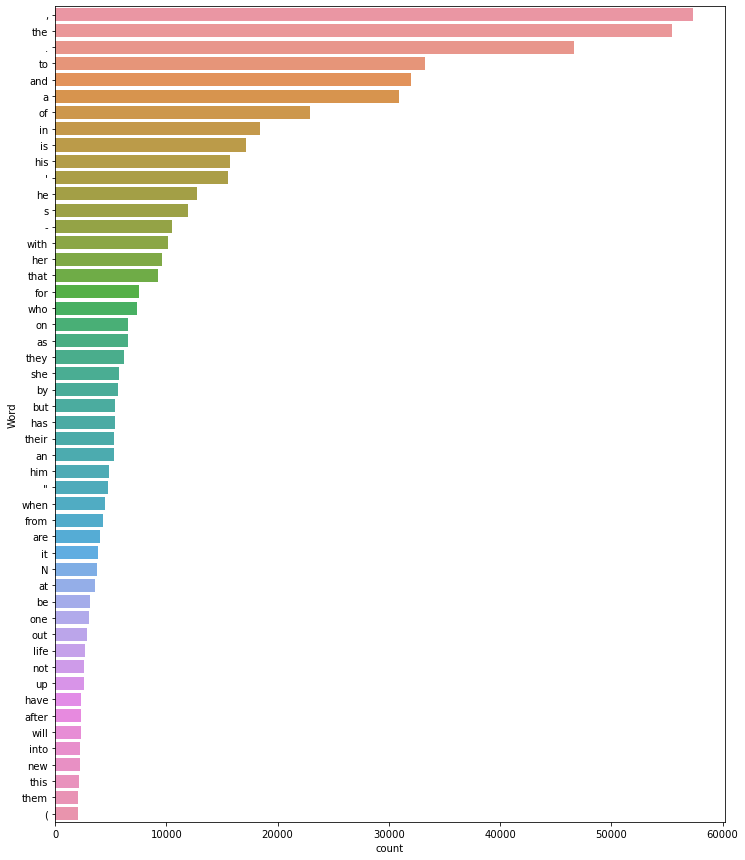

In [13]:
plt.figure(figsize=(20,20)) 
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(dataTraining['plot'], 50)

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ihernandez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ihernandez\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ihernandez\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ihernandez\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

Se evidencia en el gráfico que es necesario realizar limpieza en el texto de "plot" para poder analizar mejor el texto para predecir el gpenero de cada pelicula, esto se realizó tanto en train como en test:

In [18]:
from nltk.corpus import stopwords

In [15]:
dataTraining['nosw_plot'] = dataTraining['plot']

In [16]:
dataTesting['nosw_plot'] = dataTesting['plot']

In [19]:
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

dataTraining['nosw_plot'] = dataTraining['nosw_plot'].apply(lambda x: remove_stopwords(x))

In [20]:
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

dataTesting['nosw_plot'] = dataTesting['nosw_plot'].apply(lambda x: remove_stopwords(x))

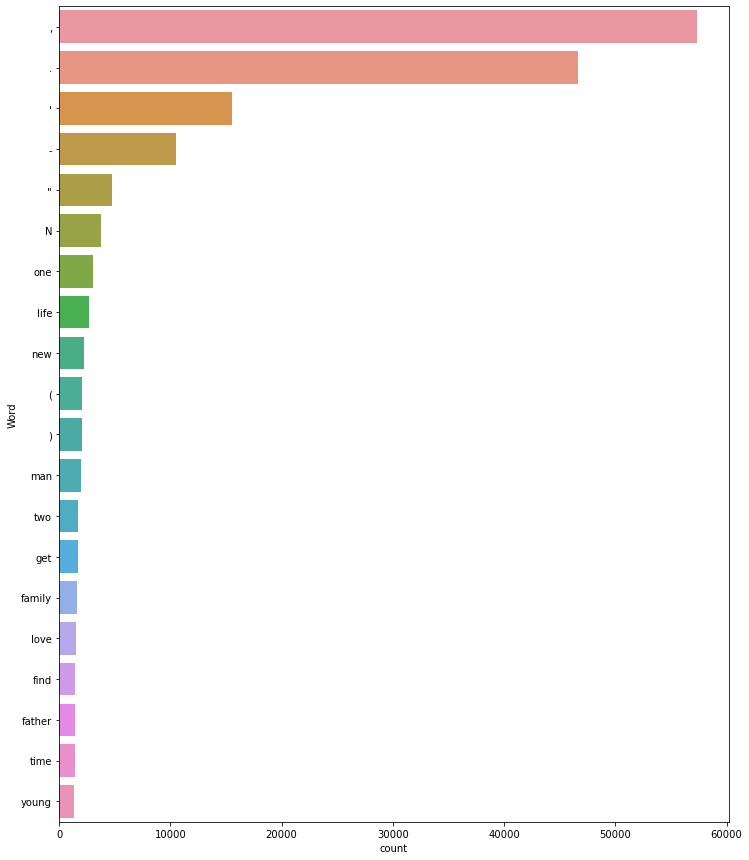

0       story single father takes eight year - old son...
1       serial killer decides teach secrets satisfying...
2       sweden , female blackmailer disfiguring facial...
3       friday afternoon new york , president tredway ...
4       los angeles , editor publishing house carol hu...
                              ...                        
7890    " marriage , wedding . " ' lesson number one n...
7891    wandering barbarian , conan , alongside goofy ...
7892    like tale spun scheherazade , kismet follows r...
7893    mrs . brisby , widowed mouse , lives cinder bl...
7894    tinker bell journey far north never land patch...
Name: nosw_plot, Length: 7895, dtype: object

In [21]:
freq_words(dataTraining['nosw_plot'], 20)
dataTraining['nosw_plot']

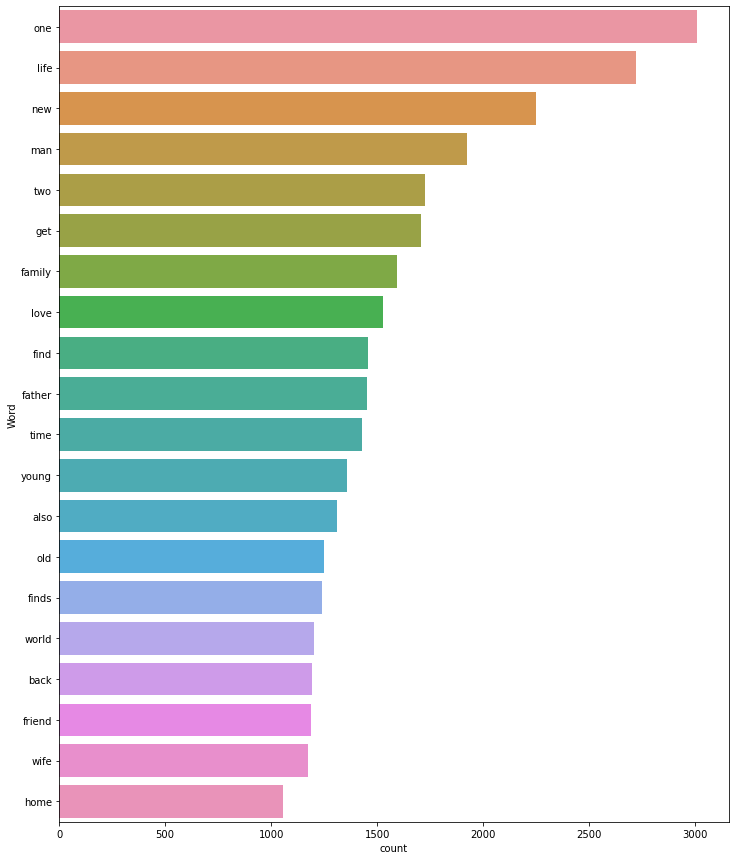

0       story single father takes eight year  old son ...
1       serial killer decides teach secrets satisfying...
2       sweden  female blackmailer disfiguring facial ...
3       friday afternoon new york  president tredway c...
4       los angeles  editor publishing house carol hun...
                              ...                        
7890     marriage  wedding    lesson number one newly ...
7891    wandering barbarian  conan  alongside goofy ro...
7892    like tale spun scheherazade  kismet follows re...
7893    mrs  brisby  widowed mouse  lives cinder block...
7894    tinker bell journey far north never land patch...
Name: nosw_plot, Length: 7895, dtype: object

In [22]:
#Eliiminar puntuacion y Ns que se usan para no escribir un número exacto
char=[' N ',';',':',',','?','.','"','-','(',')','\'',' n ']
for i in range(0,len(char)):
  dataTraining['nosw_plot']=dataTraining['nosw_plot'].apply(lambda x: x.replace(char[i],''))
freq_words(dataTraining['nosw_plot'], 20)
dataTraining['nosw_plot']

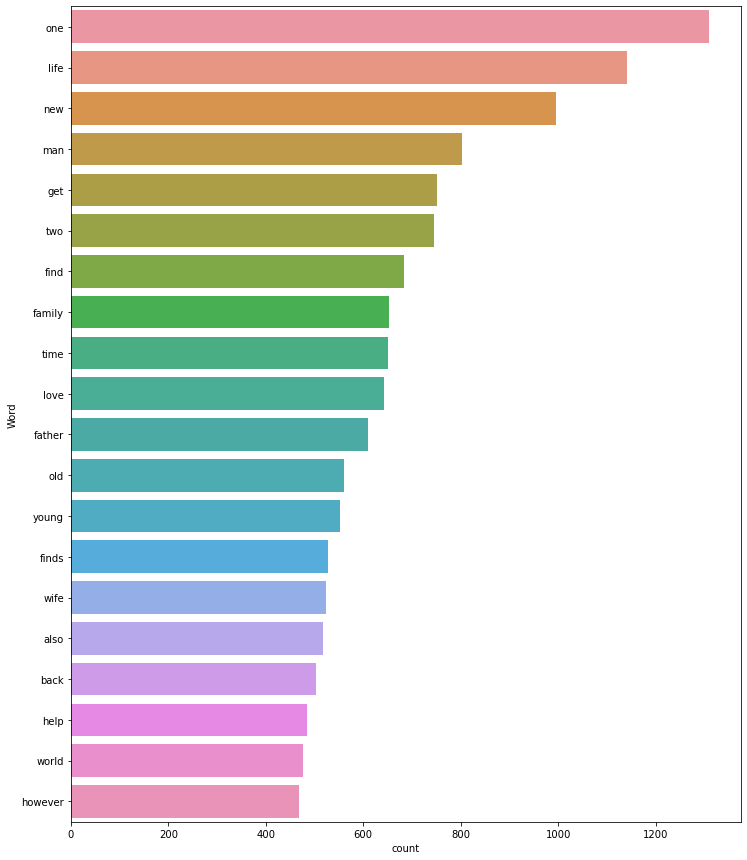

0       meets fate  shall sealed fate  theresa osborne...
1       true story billy hayes  american college stude...
2       martin vail left chicago da  office become suc...
3       husband wife americans dr  eugene mrs  helen f...
4       coroner scientist dr  warren chapin researchin...
                              ...                        
3378    bangkok  assassin turns job hits close home fi...
3379    eleven separate vignettes presented   celebrit...
3380    joey evans charming  handsome  funny  talented...
3381    singing veggies encounter car trouble   strand...
3382    genetically mutated dog stolen lab mad scienti...
Name: nosw_plot, Length: 3383, dtype: object

In [23]:
#Eliiminar puntuacion y Ns que se usan para no escribir un número exacto
char=[' N ',';',':',',','?','.','"','-','(',')','\'',' n ']
for i in range(0,len(char)):
  dataTesting['nosw_plot']=dataTesting['nosw_plot'].apply(lambda x: x.replace(char[i],''))
freq_words(dataTesting['nosw_plot'], 20)
dataTesting['nosw_plot']

### Create count vectorizer


In [24]:
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [25]:
vect_nosw = CountVectorizer(max_features=1000)
X_dtm_2 = vect_nosw.fit_transform(dataTraining['nosw_plot'])
X_dtm_2.shape

(7895, 1000)

Creación de la data input, basado en el Plot de cada película, transformado en vector

In [26]:
print(vect.get_feature_names()[:50])

['abandoned', 'able', 'about', 'accepts', 'accident', 'accidentally', 'across', 'act', 'action', 'actor', 'actress', 'actually', 'adam', 'adult', 'adventure', 'affair', 'after', 'again', 'against', 'age', 'agent', 'agents', 'ago', 'agrees', 'air', 'alan', 'alex', 'alice', 'alien', 'alive', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'america', 'american', 'among', 'an', 'and', 'angeles', 'ann', 'anna', 'another', 'any', 'anyone', 'anything']


### Create y

In [27]:
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [28]:
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [29]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [30]:
X2_train, X2_test, y2_train_genres, y2_test_genres = train_test_split(X_dtm_2, y_genres, test_size=0.33, random_state=42)

### Train multi-class multi-label model

A continuación se validarán diferentes modelos de clasficación donde se seleccionará el mejor por medio de la métrica del mayor accuracy, de igual manera se tendrá en cuenta el comportamiento del modelo en la competencia de la plataforma Kaggle:

### Regresión Lineal

In [72]:
from sklearn import linear_model

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)
regr = linear_model.LinearRegression()

In [74]:
regr.fit(X_train, y_train)

LinearRegression()

In [75]:
y_pred = regr.predict(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')

0.7701415272020969

In [76]:
#####

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [78]:
clf = OneVsRestClassifier(linear_model.LinearRegression())

In [79]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearRegression())

In [80]:
y_pred = clf.predict(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')

0.584704435084963

### Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [31]:
clf_nosw = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf_nosw.fit(X2_train, y2_train_genres)
y2_pred_genres = clf_nosw.predict_proba(X2_test)
roc_auc_score(y2_test_genres, y2_pred_genres, average='macro')

0.7654271350111982

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)
clf = RandomForestClassifier(n_jobs=-1, n_estimators=10)

In [47]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')

0.5242175319164365

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)
clf =clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-10, n_estimators=100))

In [49]:
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')

0.751056892801679

In [50]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [169]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [170]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.04,0.07,0.00,0.03,0.36,0.08,0.05,0.49,0.02,0.06,...,0.02,0.03,0.00,0.58,0.02,0.01,0.00,0.09,0.02,0.00
4,0.21,0.00,0.01,0.10,0.36,0.33,0.12,0.53,0.00,0.01,...,0.01,0.03,0.01,0.25,0.02,0.00,0.00,0.12,0.06,0.01
5,0.23,0.12,0.01,0.14,0.34,0.52,0.01,0.64,0.09,0.08,...,0.01,0.32,0.00,0.42,0.11,0.00,0.04,0.40,0.05,0.03
6,0.13,0.18,0.01,0.06,0.19,0.10,0.05,0.63,0.11,0.01,...,0.15,0.22,0.00,0.24,0.19,0.00,0.04,0.34,0.09,0.01
7,0.20,0.13,0.01,0.02,0.26,0.27,0.01,0.49,0.06,0.15,...,0.03,0.10,0.00,0.18,0.26,0.00,0.03,0.23,0.03,0.01


In [171]:
res.to_csv('pred_genres_text_RF_1.csv', index_label='ID')

### XGBoost 

Se realizan dos modelos con diferentes parámetros en donde se evidencia mejora en la predicción al ingresar el tipo de variable objetivo y el modelo basado en árboles "gbtree":


In [33]:
from xgboost import XGBClassifier

clf2 = OneVsRestClassifier(XGBClassifier(random_state=42, eval_metric='mlogloss'))
clf2.fit(X_train, y_train_genres)
y_pred_genres = clf2.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7788605626738184

In [35]:
from xgboost import XGBClassifier

clf2_nosw = OneVsRestClassifier(XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42, eval_metric='mlogloss'))
clf2_nosw.fit(X2_train, y2_train_genres)
y2_pred_genres = clf2_nosw.predict_proba(X2_test)
roc_auc_score(y2_test_genres, y2_pred_genres, average='macro')   #0.7998102029676959

0.7997064173811023

### Árboles  - Bagging

Se realizan un modelos adicionales basados en árboles para compararlos con los anteriores:

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

clf3 = OneVsRestClassifier(BaggingClassifier(base_estimator = DecisionTreeClassifier(), 
                                     n_estimators = 10, random_state = 1))

clf3.fit(X_train, y_train_genres)
y_pred_genres = clf3.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.6881098272666684

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

clf = DecisionTreeClassifier(max_depth=10, random_state=1)

In [54]:
clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)
#roc_auc_score(y_test, y_pred, average='macro')

DecisionTreeClassifier(max_depth=10, random_state=1)

In [55]:
y_pred = clf.predict(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')

0.5376464101244524

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

clf = OneVsRestClassifier(DecisionTreeClassifier(max_depth=5, random_state=1))

In [57]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                     random_state=1))

In [89]:
y_pred = clf.predict_proba(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')

0.6300077933621188

### Support Vector Machine

Se realizan dos modelos, el primero incluye solamente la especificación del tipo de predicción, el segundo se incluye un parámetro 'estimador de kernel' el cual se itera en una grilla de 1 a 10:

In [45]:
from sklearn.svm import SVC

clf4_nosw = OneVsRestClassifier(SVC(probability=True))
clf4_nosw.fit(X2_train, y2_train_genres)
y2_pred_genres = clf4_nosw.predict_proba(X2_test)
roc_auc_score(y2_test_genres, y2_pred_genres, average='macro')

0.7979883398556423

In [82]:
from sklearn import svm 
from sklearn.model_selection import GridSearchCV
parameters = {'estimator__kernel':('linear', 'rbf'), 'estimator__C':[1, 10]}
svr = OneVsRestClassifier(svm.SVC(probability=True))
clf4 = GridSearchCV(svr, parameters)
clf4.fit(X2_train, y2_train_genres)

GridSearchCV(estimator=OneVsRestClassifier(estimator=SVC(probability=True)),
             param_grid={'estimator__C': [1, 10],
                         'estimator__kernel': ('linear', 'rbf')})

In [86]:
y2_pred_genres = clf4.predict_proba(X2_test)
roc_auc_score(y2_test_genres, y2_pred_genres, average='macro')

0.7898954019180727

### Redes Neuronales

Se aplica el algoritmo de redes neuronales buscando obtener un mejor comportamiento del modelo según los datos suministrados, de igual manera se calibran diferentes parámetros que maximicen el AUC, como el número de capas y alpha:

In [58]:
 from sklearn.neural_network import MLPClassifier

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [61]:
## Redes Neuronales:

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1) ##0,7813
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')

0.7796628520306919

In [62]:
clf = MLPClassifier(solver='lbfgs', alpha=10,hidden_layer_sizes=(15,), random_state=1)##0,7856

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')


0.7907758219416646

In [63]:
clf = MLPClassifier(solver='lbfgs', alpha=10, random_state=10) ##0,8060
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')



0.8018538859923617

In [65]:
clf = MLPClassifier(solver='lbfgs', alpha=10, random_state=10, max_iter=400, validation_fraction=0.5, beta_1=0.5, power_t=0.5)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')

0.7870952785621809

In [69]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [178]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [179]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.085307,0.518914,3.471339e-03,0.005276,0.075370,0.000186,1.320725e-06,0.334831,1.133314e-02,2.081488e-01,...,0.015436,0.006903,0.000111,0.998212,0.016943,0.001761,0.000731,0.006020,1.170888e-03,4.178996e-02
4,0.012595,0.000405,9.358488e-05,0.092561,0.128184,0.687648,4.994373e-02,0.874024,2.304568e-04,1.880151e-03,...,0.002688,0.003119,0.000500,0.007049,0.001416,0.006832,0.003975,0.133415,6.883223e-03,6.652139e-03
5,0.000918,0.000002,1.139928e-08,0.008908,0.000253,0.999228,2.859522e-07,0.545655,1.118678e-08,4.856144e-07,...,0.000004,0.999858,0.000005,0.001820,0.000087,0.000013,0.000048,0.989712,4.738701e-09,2.731771e-08
6,0.009242,0.003559,2.720204e-05,0.794287,0.000019,0.000073,8.206724e-06,0.999884,5.510729e-05,4.983240e-03,...,0.000015,0.005084,0.000270,0.065732,0.163503,0.000005,0.003022,0.836543,7.914883e-02,4.558378e-03
7,0.000761,0.006008,1.099318e-03,0.000183,0.097590,0.001055,9.616870e-05,0.008343,4.026123e-04,9.160308e-01,...,0.000866,0.021666,0.000152,0.017715,0.565731,0.002145,0.000022,0.060043,2.095257e-08,4.134749e-03


In [180]:
res.to_csv('pred_genres_text_MLP.csv', index_label='ID')

In [ ]:
#####

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [67]:
clf = OneVsRestClassifier(MLPClassifier(solver='lbfgs', alpha=10,hidden_layer_sizes=(15,), random_state=1))

In [68]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=MLPClassifier(alpha=10, hidden_layer_sizes=(15,),
                                            random_state=1, solver='lbfgs'))

In [70]:
y_pred = clf.predict_proba(X_test)
##print((y_pred == y_test).mean())
roc_auc_score(y_test, y_pred, average='macro')

0.7867486102767308

In [71]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [186]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [187]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.066938,1.568144e-01,2.671012e-03,0.003190,0.034359,0.001049,4.953002e-06,0.704462,3.194161e-04,3.886657e-02,...,0.013509,0.001147,2.877714e-04,0.996937,0.041346,5.890952e-05,0.006237,0.000663,3.065647e-03,3.342552e-02
4,0.024215,1.071121e-04,2.565037e-03,0.093069,0.188797,0.162976,5.259304e-02,0.891885,2.743160e-04,2.937920e-04,...,0.005974,0.007664,3.331172e-03,0.014200,0.003603,4.043553e-03,0.001388,0.024701,1.769131e-02,5.163345e-03
5,0.000023,5.307109e-11,2.540589e-10,0.000013,0.000004,0.999983,2.004360e-06,0.918003,3.400699e-13,1.278438e-08,...,0.002165,0.999599,2.123719e-07,0.000064,0.000533,2.472529e-08,0.000159,0.995210,6.329640e-09,2.342850e-07
6,0.000040,4.115630e-02,8.391119e-07,0.079396,0.000185,0.000029,4.754204e-05,0.999239,4.853378e-06,1.734027e-03,...,0.000028,0.004502,3.052039e-05,0.566331,0.005431,7.474051e-08,0.001990,0.832148,2.608954e-01,2.337814e-04
7,0.000006,1.125956e-03,2.118533e-05,0.000026,0.456821,0.052434,5.601325e-10,0.000273,7.773342e-06,7.453784e-02,...,0.000030,0.000791,7.019000e-05,0.005946,0.284703,1.414890e-05,0.000002,0.789965,4.693409e-06,1.423591e-04


In [188]:
res.to_csv('pred_genres_text_ONE_MLP.csv', index_label='ID')

### Predict the testing dataset

In [ ]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(X_test_dtm)


### Creación del archivo respuesta para subir la predicción a Kaggle

In [ ]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [ ]:
res.head()

In [ ]:
res.to_csv('pred_genres_text_RF.csv', index_label='ID')

### Conclusiones

* La  descripción de la trama de cada pelicula, debe limpiarse con stopwords y eliminación de signos de puntuación, ya que la mayoría de las palabras inicialmente estaban dadas por preposiciones. Se evidencia que el análisis textual y la estructuración de la información puede llevar a la mejora en la predicción.

* De los modelos de clasificación basados en árboles el que genera la mejor predicción es el xgboost con un AUC de 0,79.

* El algoritmo Support Vector Machine generó un rendimiento similar a los modelos basados en árboles, por tanto se hace necesario incluir las redes neuronales para tratar de indentificar de una mejor manera la relación entre la trama y el género cinematográfico.

* Las redes neuronales generaron buen rendimiento a medida que se realizan cambios en sus parámetros, este modelo fué el seleccionado como el mejor en la clasificación de la competencia de Kaggle y en resultados del presente nootebook, con un AUC del 0,81.

* Los valores obtenido en el AUC del nootebook, son muy similares a los resultados obtenidos en Kaggle donde se espera que en el total de la data se comporten de la misma manera.

* Para mejorar la predicción del modelo se recomienda incluir los algoritmos de reconocimiento de imágenes ya que están relacionados directamente con el género de la pelicula, esto podría ser un mejora en este tipo de análisis.

## Nombre grupo Kaggle: Team 8